<a href="https://colab.research.google.com/github/guilherme-argentino/fiap-ia4devs-techchallenge-fase4/blob/main/Atividade4Corrigida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

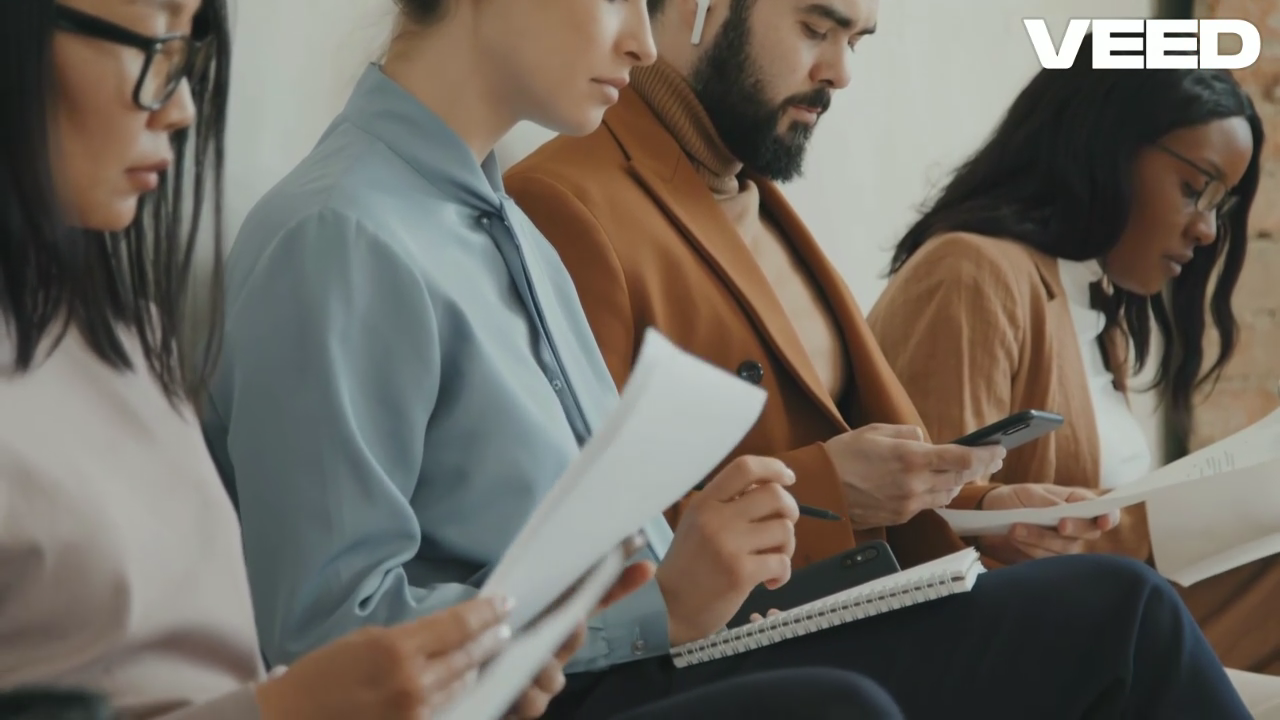

In [ ]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from google.colab.patches import cv2_imshow

def install_dependencies():
    """Install required dependencies for Google Colab."""
    !apt-get update && apt-get install -y libgl1-mesa-glx
    !pip install opencv-python matplotlib

def detect_faces(video_path, output_path):
    # Load pre-trained face detection model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Open video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get video properties
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Draw rectangles around faces
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Write the frame to output video
        out.write(frame)

        # Display the frame in Google Colab
        cv2_imshow(frame)
        clear_output(wait=True)

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Processed video saved as {output_path}")

# Install dependencies before running the function
install_dependencies()

# Example usage:
detect_faces("/content/Unlocking Facial Recognition_ Diverse Activities Analysis.mp4", "/content/output_video.mp4")
